In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/VIBGYOR dataset.zip"  # Update this with your actual path
extract_path = "/content/VIBGYOR"  # Change the destination if needed

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping complete! Files extracted to:", extract_path)

Unzipping complete! Files extracted to: /content/VIBGYOR


In [ ]:
# --- CONFIGURATION ---
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torch.multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor

In [ ]:

data_root = "/content/VIBGYOR/VIBGYOR dataset"
img_size = 224  # Adjusted for EfficientNet
band_order = ['blue','green','indigo','orange','red','violet', 'yellow']  # Band order for multispectral images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_workers = os.cpu_count()

In [ ]:
class SpectralDataset(Dataset):
    def __init__(self, data_root):
        self.samples = []
        self.class_map = {d: i for i, d in enumerate(sorted(os.listdir(data_root)))}
        self.inverse_class_map = {i: d for d, i in self.class_map.items()}

        for cls in os.listdir(data_root):
            cls_folder = os.path.join(data_root, cls)
            base_names = set('_'.join(f.split('_')[:-1]) for f in os.listdir(cls_folder) if f.endswith('.jpg'))
            for base in base_names:
                self.samples.append((os.path.join(cls_folder, base), self.class_map[cls]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        base_path, label = self.samples[idx]
        band_stack = []
        for band in band_order:
            band_path = f"{base_path}_{band}.jpg"
            img = cv2.imread(band_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))
            band_stack.append(img / 255.0)
        tensor = torch.tensor(np.stack(band_stack), dtype=torch.float32)
        return tensor, label


In [ ]:
# --- EfficientNet Model with 7-Channel Input ---
class EfficientNet7Channel(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNet7Channel, self).__init__()
        self.model = timm.create_model('efficientnet_b3', pretrained=True, in_chans=7, num_classes=num_classes)

    def forward(self, x):
        return self.model(x)


In [ ]:
# --- DataLoader ---
def threaded_loader(dataset, batch_size=16):
    def collate_fn(batch):
        xs, ys = zip(*batch)
        return torch.stack(xs), torch.tensor(ys)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)

# --- Prepare Dataset ---
dataset = SpectralDataset(data_root)
train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_set = torch.utils.data.Subset(dataset, train_idx)
val_set = torch.utils.data.Subset(dataset, val_idx)
train_loader = threaded_loader(train_set)
val_loader = threaded_loader(val_set, batch_size=1)

In [ ]:
# --- Train EfficientNet ---
model = EfficientNet7Channel(num_classes=len(dataset.class_map)).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

best_acc = 0.0
num_epochs = 40
history = {'loss': [], 'train_accuracy': [], 'val_accuracy': [], 'f1_score': []}

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train, total_train = 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            preds = model(xb)
            loss = criterion(preds, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        correct_train += (torch.argmax(preds, dim=1) == yb).sum().item()
        total_train += yb.size(0)

    train_acc = correct_train / total_train
    model.eval()
    correct_val, total_val = 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == yb).sum().item()
            total_val += yb.size(0)
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(yb.cpu().numpy())

    val_acc = correct_val / total_val
    f1 = f1_score(y_true, y_pred, average='macro')
    history['loss'].append(total_loss / len(train_loader))
    history['train_accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    history['f1_score'].append(f1)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_efficientnet_model.pth')
        print("Best model saved.")

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, F1 Score = {f1:.4f}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

<ipython-input-8-892e874f5fef>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Best model saved.
Epoch 1: Loss = 1.0184, Train Acc = 0.6632, Val Acc = 0.8042, F1 Score = 0.7808
Best model saved.
Epoch 2: Loss = 0.3072, Train Acc = 0.8854, Val Acc = 0.8764, F1 Score = 0.8533
Epoch 3: Loss = 0.2003, Train Acc = 0.9221, Val Acc = 0.8538, F1 Score = 0.8425
Epoch 4: Loss = 0.1780, Train Acc = 0.9287, Val Acc = 0.8680, F1 Score = 0.8509
Best model saved.
Epoch 5: Loss = 0.1579, Train Acc = 0.9304, Val Acc = 0.8809, F1 Score = 0.8572
Best model saved.
Epoch 6: Loss = 0.1397, Train Acc = 0.9333, Val Acc = 0.8880, F1 Score = 0.8708
Epoch 7: Loss = 0.1341, Train Acc = 0.9353, Val Acc = 0.8751, F1 Score = 0.8595
Epoch 8: Loss = 0.1253, Train Acc = 0.9399, Val Acc = 0.8815, F1 Score = 0.8532
Epoch 9: Loss = 0.1276, Train Acc = 0.9343, Val Acc = 0.8880, F1 Score = 0.8673
Epoch 10: Loss = 0.1236, Train Acc = 0.9383, Val Acc = 0.8828, F1 Score = 0.8622
Best model saved.
Epoch 11: Loss = 0.1272, Train Acc = 0.9399, Val Acc = 0.8892, F1 Score = 0.8768
Epoch 12: Loss = 0.1134, Tra

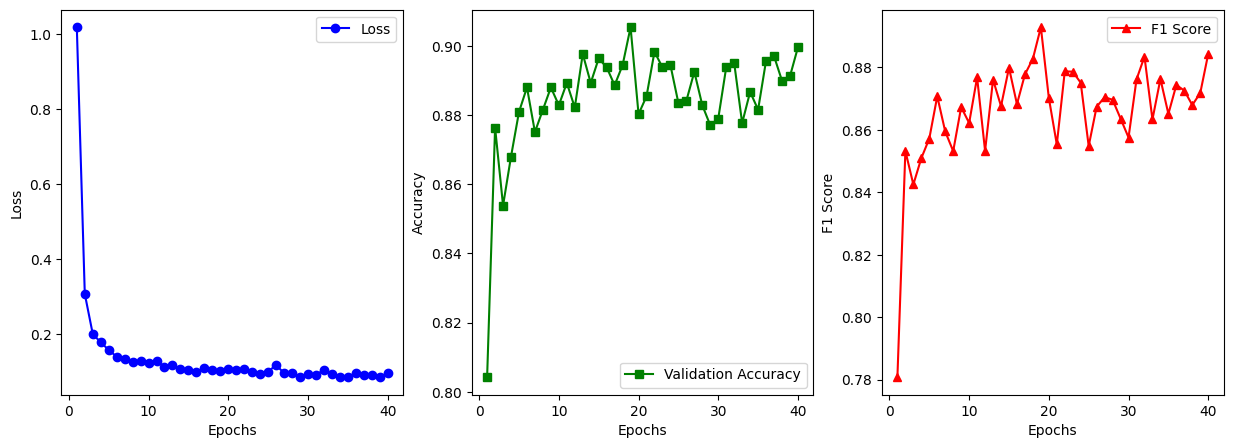

In [ ]:
# --- Plot Training Metrics ---
def plot_training_metrics(history):
    epochs = range(1, len(history['loss']) + 1)
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, history['loss'], marker='o', linestyle='-', color='b', label="Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, history['val_accuracy'], marker='s', linestyle='-', color='g', label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, history['f1_score'], marker='^', linestyle='-', color='r', label="F1 Score")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.show()

plot_training_metrics(history)


Classification Report:
                      precision    recall  f1-score   support

           Calculus       0.59      0.72      0.65       175
        Data caries       0.99      0.97      0.98       344
         Gingivitis       0.85      0.78      0.81       372
        Mouth Ulcer       0.99      0.99      0.99       374
Tooth Discoloration       0.97      0.97      0.97       246
         hypodontia       0.93      0.88      0.90        42

           accuracy                           0.90      1553
          macro avg       0.89      0.89      0.88      1553
       weighted avg       0.91      0.90      0.90      1553



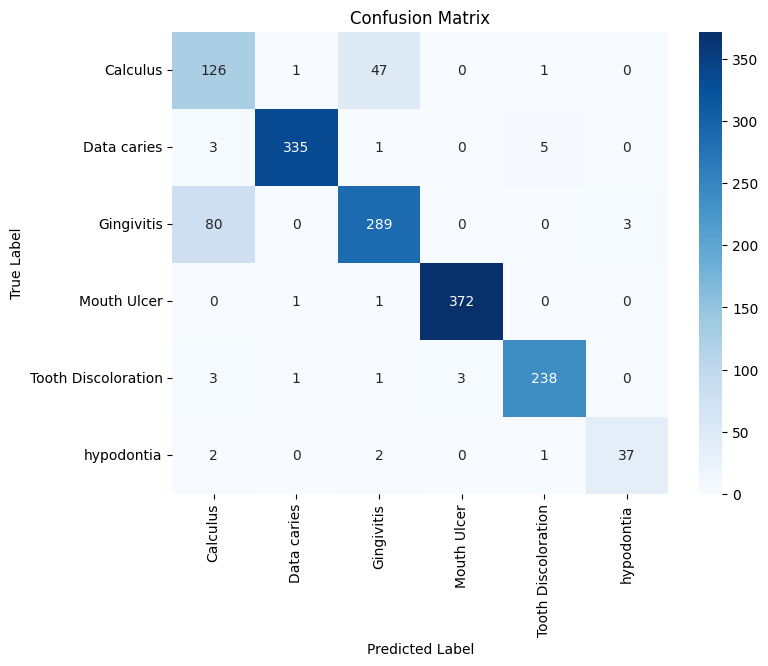

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, dataloader, dataset):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(yb.cpu().numpy())

    # Compute Classification Report
    class_labels = list(dataset.class_map.keys())
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))

    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function after training
evaluate_model(model, val_loader, dataset)


In [ ]:
import cv2
import numpy as np
import torch

# Your class names (in the same order as dataset.class_map)
class_names = ['Calculus', 'Data caries', 'Gingivitis', 'Mouth Ulcer', 'Tooth Discoloration', 'hypodontia']

# Band order used during training
band_order = ['blue', 'green', 'indigo', 'orange', 'red', 'violet', 'yellow']

# Load multispectral 7-band image
def load_multispectral_sample(base_path, img_size=224):
    bands = []
    for band in band_order:
        band_path = f"{base_path}_{band}.jpg"
        img = cv2.imread(band_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"❌ Missing image: {band_path}")
        img = cv2.resize(img, (img_size, img_size))
        img = img.astype(np.float32) / 255.0  # Normalize
        bands.append(img)
    stacked = np.stack(bands)  # Shape: (7, 224, 224)
    tensor = torch.tensor(stacked).unsqueeze(0).to(device)  # Shape: (1, 7, 224, 224)
    return tensor

# Predict class from sample
def predict_sample(base_path, model):
    try:
        input_tensor = load_multispectral_sample(base_path)
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            predicted_class = class_names[predicted.item()]
            print(f"✅ Predicted class: {predicted_class}")
            return predicted_class
    except FileNotFoundError as e:
        print(str(e))
        return None

In [ ]:

# Load the model
import torch.nn as nn
import timm

class CustomEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet_b3', in_channels=7, num_classes=6):
        super(CustomEfficientNet, self).__init__()
        self.model = timm.create_model(
            model_name,
            pretrained=True,
            in_chans=in_channels,
            num_classes=num_classes
        )

    def forward(self, x):
        return self.model(x)

model_path = "/content/drive/MyDrive/Colab Notebooks/best_efficientnetv2_model.pth"
model = CustomEfficientNet(model_name='efficientnet_b3', in_channels=7, num_classes=6)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# ✅ Define the base path (without .jpg)
base_path = "/content/VIBGYOR/VIBGYOR dataset/Mouth Ulcer/Mouth_Ulcer_0_1007"

# ✅ Run prediction
predicted = predict_sample(base_path, model)

✅ Predicted class: Mouth Ulcer
